<a href="https://colab.research.google.com/github/kurav/FindLungNodules/blob/main/pydicom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MKN (07.11.2022) The essential packages installation
!pip install pydicom
#!pip install vedo
!pip install opencv-python
!pip install vtk
#!pip install gdcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#MKN: Import the required packages and mount the drive where DICOM images exist
import matplotlib.pyplot as plt
import pydicom
import os
from pathlib import Path
import numpy as np
import vtk
import cv2
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import seaborn as sns
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm
from IPython.display import HTML
from PIL import Image
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading the DICOM images in .dcm format from the specified drive (prerequisite: drive should be mounted)
directory = r"/content/drive/MyDrive/Project - MKN Abhishek Varshit (Lungs Nodule Detection on CT)/LUNG1-001_20190225_CT_3_28_2020_6_32_43/LUNG1-001_20190225_CT/"
slices = []
files = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      if f.endswith(".dcm"):
        dsname= directory+filename
        files.append(pydicom.dcmread(dsname,force=True))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation attribute
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# sorting slices in order
slices = sorted(slices, key=lambda s: s.SliceLocation)
#for i in range(len(files)):
  #print(slices[i].SliceLocation)
print(slices[0].pixel_array)



Streaming output truncated to the last 5000 lines.
    11   31   50   46   31   19   13   23   26   45   58   50   19    5
    15   21   34   42   53   53   34   30   47   55   44   28   31   42
    40   17    8   26   36    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   28   10   19   39   35   44   39   27   34   26   20
    22   31   24   14    9    9   12   14   24   20   30   39   34   37
    33   39   58   50   48   36   32   41   33   17    3    0   32   52
    33    0    4   17   23   24   15    4   23   43   38   33   26   24
    38   27   13    3    8   16    7    9   10   19   14   13   74  174
   169   71   25   16   21   46   99  193  180   68   26   15   30   52
    48   30   16    9   18   18   12    3 

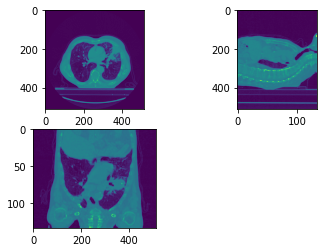

In [ ]:
# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [ ]:
def connected_component_label(path):

    img = path


    # Converting those pixels with values 1-127 to 0 and others to 1
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
    # Applying cv2.connectedComponents()

    num_labels, labels = cv2.connectedComponents(np.uint8(img))

    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    # Showing Original Image
    plt.imshow(cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()

    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

In [ ]:
def thresh_img(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]

    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')

        plt.show()
    return thresh_img

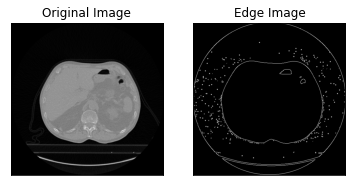

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:706: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



TypeError: ignored

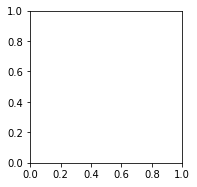

In [ ]:
x = slices[22].pixel_array
threshnew= thresh_img(x)
edges = cv2.Canny(np.uint8(threshnew),0.5,1)
plt.subplot(121),plt.imshow(x,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

#kernel = np.ones((3,3), np.uint8)
# erosion_image = cv2.erode(input_image, kernel, iterations=1)
# dilation_image = cv2.dilate(input_image, kernel, iterations=1)
# Displaying the input and output image
# plt.subplot(122),plt.imshow(canny_img,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
# plt.show()
#print(x)
analysis = cv2.connectedComponentsWithStats(edges,4,cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis

output = np.zeros(x.shape, dtype="uint8")
for i in range(1, totalLabels):
    area = values[i, cv2.CC_STAT_AREA]
    x = values[i, cv2.CC_STAT_LEFT]
    y = values[i, cv2.CC_STAT_TOP]
    h,w = edges.shape[:2]


    if (area>50):

        # Labels stores all the IDs of the components on the each pixel
        # It has the same dimension as the threshold
        # So we'll check the component
        # then convert it to 255 value to mark it white
        componentMask = (label_ids == i).astype("uint8") * 255

        # Creating the Final output mask
        components = cv2.bitwise_or(output, componentMask)
        mask = np.zeros((h+2,w+2),np.uint8)
        filled = cv2.floodFill(components,mask,(0,0),(255,255,255))
        plt.subplot(122),plt.imshow(filled,cmap = 'gray')
        plt.title('components'), plt.xticks([]), plt.yticks([])
        plt.show()
# connected_component_label(edges)

In [ ]:
#test module delete if not used


contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(x.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
from google.colab.patches import cv2_imshow


In [ ]:
def set_outside_scanner_to_air(raw_pixelarrays):
    # outside region and air has values <-1000 and is ignored
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

In [ ]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)

    # convert to HU
    for n in range(len(slices)):

        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope

        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)

        images[n] += np.int16(intercept)

    return np.array(images, dtype=np.int16)

In [ ]:
hu_scans = transform_to_hu(slices)

In [ ]:
def plot_3d(image, threshold=350, color="navy"):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

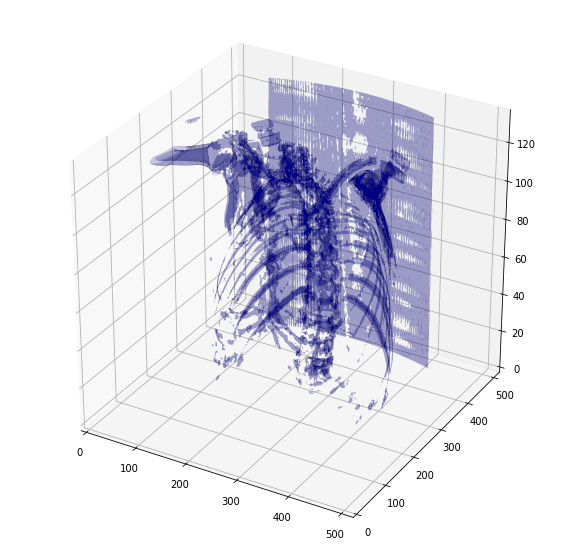

In [ ]:
plot_3d(hu_scans)

In [ ]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)

    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)

        bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]]) #[0,:] = [row_0 , first column:last column]
        for bad_label in bad_labels:
            binary_image[labels == bad_label] = 2


        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1

        segmented[n] = binary_image.copy() * image[n]

    return segmented

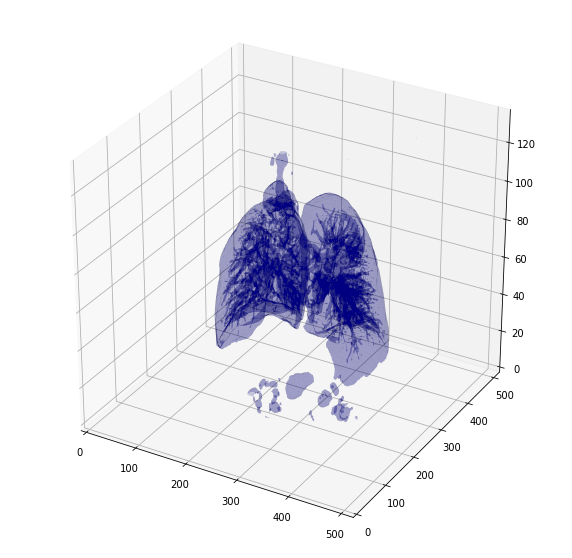

In [ ]:
segmented_lungs = segment_lung_mask(hu_scans)
plot_3d(segmented_lungs, threshold=-600)